In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y_parallel
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Solve HJB

In [2]:
# Intensity parameter
τ = .25

r0 = 1.5
r1 = 2.5

# Robustness parameters
ξ_b = 100000.
ξ_p = 5.
ξ_a = 1./100

n_model = 40
damage_setting={'γ_2p': np.linspace(0, 1./3, n_model),
                'πd_o': np.ones(n_model)/n_model}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 2.0
y_bar_lower = 1.5

# Grid setting
ϵ = 2.
y_step = .02
y_grid_long = np.arange(0., y_bar_upper*2+y_step, y_step)
y_grid_short = np.arange(0., y_bar_upper+y_step, y_step)
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper)

In [3]:
# Parallelly solve ODE
model_args_list = []
model_list = []

for i in range(n_model):
    temp = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_a, γ_1, γ_2, γ_2p[i], y_bar_upper)
    model_args_list.append((y_grid_long, temp, None, ϵ, 1e-8, 2000, False))

model_list = ode_y_parallel(model_args_list)

In [4]:
# Prepare ϕ_m
ϕ_m = np.zeros((n_model, len(y_grid_short)))
for i in range(n_model):
    ϕ_m[i, :] = model_list[i]['v0'][y_bar_upper_loc]

ϕ_post_jump = np.zeros((n_model, len(y_grid_long)))
for i in range(n_model):
    ϕ_post_jump[i, :] = model_list[i]['v0']
    
# Prepare v_guess
v_guess = np.average(np.array([model_list[i]['v0'][:y_bar_upper_loc+1] for i in range(len(model_list))]),
                     weights=np.ones(len(model_list))/len(model_list), axis=0)

In [5]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5,
                                  tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, τ = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = - η * (y_grid + y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    intensity = r0 * (np.exp(r1 / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
                + 0 * (y_grid < y_bar_lower)

    e_tilde = 0.
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives(v0, 2, Δ_y)

        G = v0_dy + (η-1)/δ*d_Λ

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)

        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.5 + e_tilde_old*.5
 
        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

        A = np.ones_like(y_grid)*(-δ) - intensity * np.sum(πd_o * g, axis=0)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)\
            + intensity * np.sum(πd_o * g * ϕ_i, axis=0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, 0), (False, False))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m
    πd = g / np.sum(πd_o * g, axis=0) * πd_o

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'intensity': intensity,
           'πc': πc,
           'πd': πd,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [6]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, τ)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=1,
                                          tol=1e-8, max_iter=2000, print_all=True)

Iteration 1: LHS Error: 0.1717793407819771; RHS Error 0.17169171199011554
Iteration 2: LHS Error: 0.1336327444710813; RHS Error 0.13445619987178814
Iteration 3: LHS Error: 0.11011432631811757; RHS Error 0.11132107315089414
Iteration 4: LHS Error: 0.09352555487610292; RHS Error 0.0953568513285456
Iteration 5: LHS Error: 0.08143919549101819; RHS Error 0.08362796926174446
Iteration 6: LHS Error: 0.07237639523856709; RHS Error 0.07475873669383788
Iteration 7: LHS Error: 0.06542688366094795; RHS Error 0.0678329967879167
Iteration 8: LHS Error: 0.059898689685405904; RHS Error 0.062188917491376366
Iteration 9: LHS Error: 0.05533013709374501; RHS Error 0.057810458745288874
Iteration 10: LHS Error: 0.05145666389270487; RHS Error 0.05410342225933586
Iteration 11: LHS Error: 0.04839003568698219; RHS Error 0.05092826546730657
Iteration 12: LHS Error: 0.04555875413987753; RHS Error 0.04830009023383609
Iteration 13: LHS Error: 0.04336695436456073; RHS Error 0.04600389531881953
Iteration 14: LHS Erro

Iteration 135: LHS Error: 0.005573681859283308; RHS Error 0.005270799772460026
Iteration 136: LHS Error: 0.005505590865772625; RHS Error 0.005206640376921805
Iteration 137: LHS Error: 0.0054377127033111705; RHS Error 0.005145611085389239
Iteration 138: LHS Error: 0.005372654125070042; RHS Error 0.005084641666832972
Iteration 139: LHS Error: 0.0053082332584417635; RHS Error 0.0050238816239401435
Iteration 140: LHS Error: 0.005244059710841853; RHS Error 0.0049634577338430255
Iteration 141: LHS Error: 0.00518025495458474; RHS Error 0.004904968310440544
Iteration 142: LHS Error: 0.005117471347645175; RHS Error 0.0048475703397411266
Iteration 143: LHS Error: 0.005056747330270728; RHS Error 0.004790509002501005
Iteration 144: LHS Error: 0.004996385731414588; RHS Error 0.0047338733645850214
Iteration 145: LHS Error: 0.004936472037726958; RHS Error 0.004677738197009791
Iteration 146: LHS Error: 0.004877078006874314; RHS Error 0.004622787543143492
Iteration 147: LHS Error: 0.004818263366075826;

Iteration 264: LHS Error: 1.1097694709860662e-06; RHS Error 0.002781960973543822
Iteration 265: LHS Error: 1.0946254143107126e-06; RHS Error 0.002781956210461574
Iteration 266: LHS Error: 1.078240155827359e-06; RHS Error 0.002781951915557343
Iteration 267: LHS Error: 1.0636028107136042e-06; RHS Error 0.0027819480450900907
Iteration 268: LHS Error: 1.04774680087516e-06; RHS Error 0.002781944559099331
Iteration 269: LHS Error: 1.0336586773185275e-06; RHS Error 0.0027819414211184626
Iteration 270: LHS Error: 1.0182463756613913e-06; RHS Error 0.0027819385979064998
Iteration 271: LHS Error: 1.0047355751829912e-06; RHS Error 0.002781936059190089
Iteration 272: LHS Error: 9.898041706257743e-07; RHS Error 0.0027819337774376077
Iteration 273: LHS Error: 9.767753672562662e-07; RHS Error 0.0027819317276301797
Iteration 274: LHS Error: 9.625813124358729e-07; RHS Error 0.0027819298870517956
Iteration 275: LHS Error: 9.49720342813265e-07; RHS Error 0.0027819282351020935
Iteration 276: LHS Error: 9.3

Iteration 399: LHS Error: 4.2115624765415305e-08; RHS Error 0.0027819157420595694
Iteration 400: LHS Error: 3.94963084460187e-08; RHS Error 0.0027819157308962145
Iteration 401: LHS Error: 3.701476813944282e-08; RHS Error 0.0027819157199171773
Iteration 402: LHS Error: 3.4665815107359776e-08; RHS Error 0.002781915709132818
Iteration 403: LHS Error: 3.244429258586479e-08; RHS Error 0.0027819156985634044
Iteration 404: LHS Error: 3.0345070456405665e-08; RHS Error 0.0027819156882244386
Iteration 405: LHS Error: 2.8363078108384343e-08; RHS Error 0.002781915678129278
Iteration 406: LHS Error: 2.649331065640581e-08; RHS Error 0.0027819156682868176
Iteration 407: LHS Error: 2.4730835157527054e-08; RHS Error 0.0027819156587108457
Iteration 408: LHS Error: 2.307082969110752e-08; RHS Error 0.002781915649405442
Iteration 409: LHS Error: 2.1508561154348627e-08; RHS Error 0.002781915640378392
Iteration 410: LHS Error: 2.0039409243111095e-08; RHS Error 0.002781915631631611
Iteration 411: LHS Error: 1

Text(0, 0.5, '$\\phi(y)$')

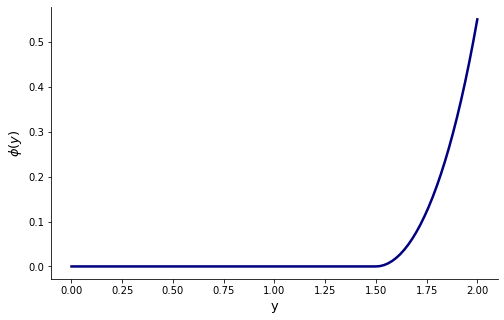

In [7]:
# Figure 1
plt.figure(figsize=(8, 5))
plt.plot(y_grid_short, model_res['intensity'], color='navy', linewidth=2.5)
plt.xlabel('y', fontsize=13)
plt.ylabel(r'$\phi(y)$', fontsize=13)
# plt.savefig('../plots/paper_plots/value_function.pdf')

Text(0, 0.5, '$\\phi(y)$')

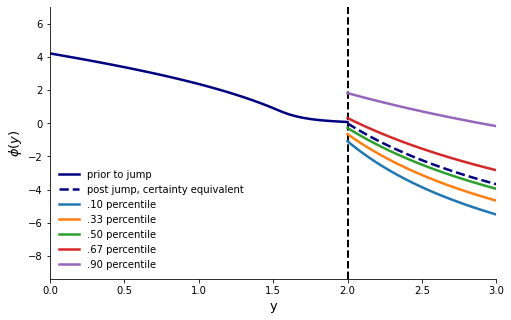

In [8]:
# Figure 2
certainty_equivalent = - ξ_p * np.log(np.average(np.exp(- 1. / ξ_p * ϕ_post_jump),
                                                 axis=0, weights=damage_setting['πd_o']))
p10_loc = find_nearest_value(ϕ_post_jump[:, y_bar_upper_loc], np.percentile(ϕ_post_jump[:, y_bar_upper_loc], 10))
p33_loc = find_nearest_value(ϕ_post_jump[:, y_bar_upper_loc], np.percentile(ϕ_post_jump[:, y_bar_upper_loc], 33))
p50_loc = find_nearest_value(ϕ_post_jump[:, y_bar_upper_loc], np.percentile(ϕ_post_jump[:, y_bar_upper_loc], 50))
p67_loc = find_nearest_value(ϕ_post_jump[:, y_bar_upper_loc], np.percentile(ϕ_post_jump[:, y_bar_upper_loc], 67))
p90_loc = find_nearest_value(ϕ_post_jump[:, y_bar_upper_loc], np.percentile(ϕ_post_jump[:, y_bar_upper_loc], 90))

plt.figure(figsize=(8, 5))

plt.plot(y_grid_short, model_res['v0'], color='navy', linewidth=2.5, label='prior to jump')
plt.plot(y_grid_long[y_grid_long>=y_bar_upper], certainty_equivalent[y_grid_long>=y_bar_upper],
         color='navy', linewidth=2.5, linestyle='dashed', label='post jump, certainty equivalent')
plt.plot(y_grid_long[y_grid_long>=y_bar_upper], ϕ_post_jump[p10_loc][y_grid_long>=y_bar_upper],
         linewidth=2.5, label='.10 percentile')
plt.plot(y_grid_long[y_grid_long>=y_bar_upper], ϕ_post_jump[p33_loc][y_grid_long>=y_bar_upper],
         linewidth=2.5, label='.33 percentile')
plt.plot(y_grid_long[y_grid_long>=y_bar_upper], ϕ_post_jump[p50_loc][y_grid_long>=y_bar_upper],
         linewidth=2.5, label='.50 percentile')
plt.plot(y_grid_long[y_grid_long>=y_bar_upper], ϕ_post_jump[p67_loc][y_grid_long>=y_bar_upper],
         linewidth=2.5, label='.67 percentile')
plt.plot(y_grid_long[y_grid_long>=y_bar_upper], ϕ_post_jump[p90_loc][y_grid_long>=y_bar_upper],
         linewidth=2.5, label='.90 percentile')

y_min = np.min(ϕ_post_jump)*1.2
y_max = np.max(ϕ_post_jump)*1.2
plt.vlines(2., ymin=y_min, ymax=y_max, color='black', linestyle='dashed', linewidth=2.)
plt.xlim(0, 3.)
plt.ylim(y_min, y_max)
plt.legend(frameon=False)
plt.xlabel('y', fontsize=13)
plt.ylabel(r'$\phi(y)$', fontsize=13)
# plt.savefig('../plots/paper_plots/value_function.pdf')

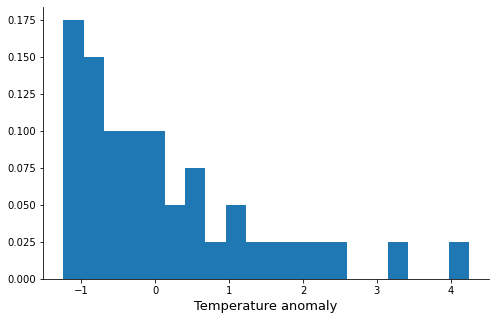

In [9]:
# Figure 3
plt.figure(figsize=(8, 5))
plt.hist(ϕ_m[:, -1], bins=20, weights=damage_setting['πd_o'])
plt.xlabel('Temperature anomaly', fontsize=13)
plt.show()

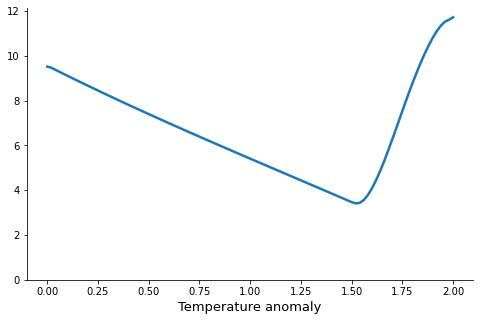

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(y_grid_short, model_res['e_tilde'], linewidth=2.5)
plt.ylim(0, None)
plt.xlabel('Temperature anomaly', fontsize=13)
plt.show()

## Simulation

In [11]:
def simulation(y_grid, e_grid, h_grid, g_grid, θ=1.86/1000.,
               y_start=.5394, T=100, dt=1):
    Et = np.zeros(int(T/dt)+1)
    yt = np.zeros(int(T/dt)+1)
    ht = np.zeros(int(T/dt)+1)
    gt = np.zeros((len(g_grid), int(T/dt)+1))
    for i in range(int(T/dt)+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ht[i] = np.interp(y_start, y_grid, h_grid)
        for n in range(gt.shape[0]):
            gt[n, i] = np.interp(y_start, y_grid, g_grid[n])
        yt[i] = y_start
        y_start = y_start + Et[i]*θ*dt
    return Et, yt, ht, gt

In [12]:
e_grid_no_jump = model_res['e_tilde']
e_grid_post_jump = np.array([model['e_tilde'] for model in model_list])

In [15]:
def simulation_prob(y_grid_short, y_grid_long, e_grid_no_jump, e_grid_jump,
                        θ, y0, y_bar_lower, y_bar_upper, r0, r1, τ, damage_prob, γ_2p, n_model, T=100):
    """
    y_grid : (N,) ndarray
    e_grid_no_jump : (N,) ndarray
    e_grid_post_jump : (n_model, N) ndarray
    """
    et_paths = []
    yt_paths = []
    yt_state_paths = []
    γ2pt_paths = []
    paths_prob = []

    yt_pre_jump = np.zeros(int(T/τ)+1)
    et_pre_jump = np.zeros(int(T/τ)+1)
    γ2pt_pre_jump = np.ones(int(T/τ)+1) * (-1) # -1 if γ_2p is not revealed        
    t_count = 0

    # path piror to y_bar_lower
    while y0 <= y_bar_lower:
        et_pre_jump[t_count] = np.interp(y0, y_grid_short, e_grid_no_jump)
        yt_pre_jump[t_count] = y0
        y0 = y0 + et_pre_jump[t_count] * θ * τ
        t_count += 1

    # add n_model paths at every time point
    no_jump_prob = 1.
    for t in range(t_count, int(T/τ)+1):
        if y0 < y_bar_upper:
            intensity = r0 * (np.exp(r1 / 2. * (y0-y_bar_lower)**2) - 1.) * (y0 >= y_bar_lower)\
                        + 0 * (y0 < y_bar_lower)            
            jump_prob = τ * intensity
            for i in range(n_model):
                # compute unconditional prob
                jump_prob_to_i = damage_prob[i] * jump_prob * no_jump_prob
                paths_prob.append(jump_prob_to_i)
                # compute path
                yt = yt_pre_jump.copy()
                et = et_pre_jump.copy()
                γ2pt = γ2pt_pre_jump.copy()
                for j in range(t_count, t):
                    yt[j] = yt[j-1] + et[j-1] * θ * τ
                    et[j] = np.interp(yt[j], y_grid_short, e_grid_no_jump)
                e_grid_realized = e_grid_jump[i]
                yt_state = yt.copy()
                for j in range(t, int(T/τ)+1):
                    γ2pt[j] = γ_2p[i]
                    if j == t:
                        yt_state[j] = y_bar_upper
                    else:
                        yt_state[j] = yt_state[j-1] + et[j-1] * θ * τ
                    yt[j] = yt[j-1] + et[j-1] * θ * τ
                    et[j] = np.interp(yt_state[j], y_grid_long, e_grid_realized)
                et_paths.append(et)
                yt_paths.append(yt)
                yt_state_paths.append(yt_state)
                γ2pt_paths.append(γ2pt)
            no_jump_prob *= (1.-jump_prob)
        e_no_jump = np.interp(y0, y_grid_short, e_grid_no_jump)
        y0 = y0 + e_no_jump * θ * τ

    return np.array(et_paths), np.array(yt_paths), np.array(yt_state_paths), np.array(γ2pt_paths), np.array(paths_prob)

In [84]:
et_paths, yt_paths, yt_state_paths, γ2pt_paths, paths_prob = simulation_prob(y_grid_short, y_grid_long, e_grid_no_jump, e_grid_post_jump,
                           np.mean(model_res['θ']), y0=1.1, y_bar_lower=y_bar_lower, y_bar_upper=y_bar_upper, r0=r0,
                           r1=r1, τ=τ, damage_prob=damage_setting['πd_o'], γ_2p=damage_setting['γ_2p'], n_model=n_model, T=94)

In [86]:
T = 94
time_periods = np.arange(0, T+τ, τ)
et_no_jump, yt_no_jump, _, _ = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                                          θ=np.mean(model_res['θ']), y_start=1.1, T=T, dt=τ)

In [93]:
paths_prob.shape

(6880,)

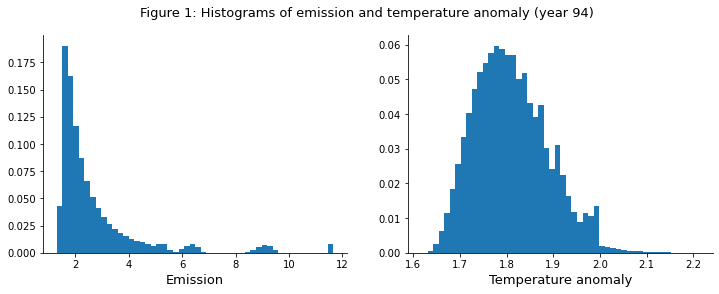

In [114]:
et_paths_T = np.zeros(et_paths.shape[0]+1)
yt_paths_T = np.zeros(yt_paths.shape[0]+1)
et_paths_T[:et_paths.shape[0]] = et_paths[:, int(T/τ)]
yt_paths_T[:yt_paths.shape[0]] = yt_paths[:, int(T/τ)]
et_paths_T[et_paths.shape[0]] = et_no_jump[int(T/τ)]
yt_paths_T[yt_paths.shape[0]] = yt_no_jump[int(T/τ)]
paths_prob_T = np.zeros(paths_prob.shape[0]+1)
paths_prob_T[:paths_prob.shape[0]] = paths_prob
paths_prob_T[paths_prob.shape[0]] = 1-paths_prob.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(et_paths_T, weights=paths_prob_T, density=False, bins=50)
ax2.hist(yt_paths_T, weights=paths_prob_T, density=False, bins=50)
ax1.set_xlabel('Emission', fontsize=13)
ax2.set_xlabel('Temperature anomaly', fontsize=13)
fig.suptitle('Figure 1: Histograms of emission and temperature anomaly (year '+str(T)+')', fontsize=13)

plt.savefig('fig_1.pdf')

In [109]:
e_temp = et_paths_T[et_paths_T>8]
prob_temp = paths_prob_T[et_paths_T>8]
e_selected = e_temp[e_temp<10]
prob_selected = prob_temp[e_temp<10]
prob_selected.sum()

0.024805600625477646

In [110]:
e_selected.shape

(172,)

In [101]:
et_paths_T.shape

(6881,)

In [31]:
# Compute no jump probability
no_jump_prob = np.ones_like(yt_no_jump)
for t in range(no_jump_prob.shape[0]):
    y = yt_no_jump[t]
    if y > y_bar_lower:
        intensity = r0 * (np.exp(r1 / 2. * (y-y_bar_lower)**2) - 1.) * (y >= y_bar_lower)\
                    + 0 * (y < y_bar_lower)
        no_jump_prob[t] = (1 - intensity*τ) * no_jump_prob[t-1]

(0.0, 1.05)

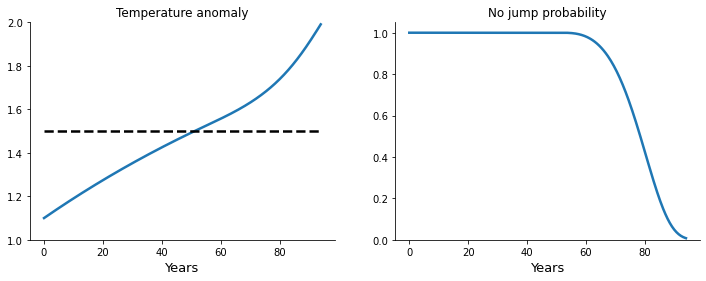

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(time_periods, yt_no_jump, linewidth=2.5)
ax1.plot(time_periods, np.ones_like(yt_no_jump)*1.5, linestyle='dashed', color='black', linewidth=2.5)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_title(r'Temperature anomaly')
ax1.set_ylim(1, 2)

ax2.plot(time_periods, no_jump_prob, linewidth=2.5)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_title(r'No jump probability')
ax2.set_ylim(0, 1.05)

# fig.savefig('fig_2.pdf')

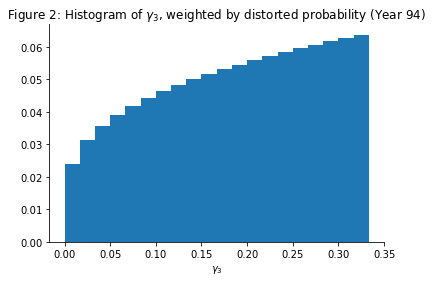

In [142]:
# Implied distorted probabilities
yt_loc = find_nearest_value(model_res['y_grid'], yt_no_jump[int(T/τ)])
Gt_m = model_res['g'][:, yt_loc]
πd = Gt_m*πd_o / np.sum(Gt_m*πd_o)
plt.hist(γ_2p, weights=πd, bins=20)
plt.xlabel(r'$\gamma_3$')
plt.title(r'Figure 2: Histogram of $\gamma_3$, weighted by distorted probability (Year ' + str(T) + ')')
plt.savefig('fig_2.pdf')

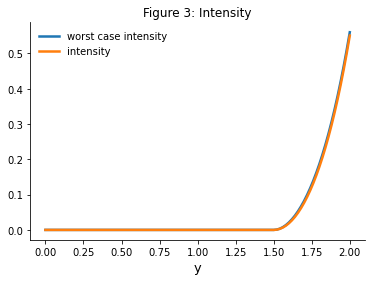

In [122]:
intensity = r0 * (np.exp(r1 / 2. * (y_grid_short-y_bar_lower)**2) - 1.) * (y_grid_short >= y_bar_lower)\
                        + 0 * (y_grid_short < y_bar_lower)
plt.plot(y_grid_short, np.average(model_res['g'], axis=0)*intensity, label='worst case intensity', linewidth=2.5)
plt.plot(y_grid_short, intensity, label='intensity', linewidth=2.5)
plt.legend(frameon=False)
plt.xlabel('y', fontsize=13)
plt.title('Figure 3: Intensity')
plt.savefig('fig_3.pdf')

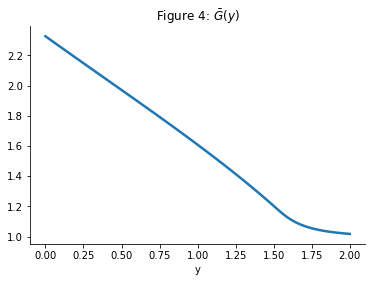

In [135]:
plt.plot(y_grid_short, np.average(model_res['g'], axis=0), linewidth=2.5)
plt.xlabel('y')
plt.title(r'Figure 4: $\bar{G}(y)$')
plt.savefig('fig_4.pdf')